In [1]:
import datetime

import yfinance as yf
import numpy as np
import pandas as pd 
from statsmodels.tsa.stattools import adfuller
from ripser import Rips
from tqdm import tqdm
from persim.persistent_entropy import persistent_entropy
from persim import wasserstein
from persim import plot_diagrams
from scipy import stats
# ignore persim warnings
import warnings
warnings.filterwarnings("ignore")

In [2]:
pd.__version__

'1.5.3'

# Load list of S&P 500 companies

In [3]:
df_sp500_companies = pd.read_html('https://en.wikipedia.org/wiki/List_of_S%26P_500_companies')[0]

In [4]:
# get string of ticker names
ticker_names = str(df_sp500_companies['Symbol'].to_list()).replace("'", "").replace("[", "").replace("]", "").replace(",", "")
index_names = df_sp500_companies['Symbol'].to_list()
# Add overall S&P 500 stock index data --> aim to forecast it's values
index_names = ['^GSPC'] + index_names

In [5]:
# Set date range
start_date = "2018-01-01"
end_date = "2023-01-01"

# Get data from yahoo finance
index_data = yf.download(index_names, start=start_date, end=end_date)
index_data.shape

[*********************100%***********************]  504 of 504 completed

2 Failed downloads:
- BRK.B: No timezone found, symbol may be delisted
- BF.B: No data found for this date range, symbol may be delisted


(1259, 3024)

In [7]:
# Resample to weekly data
index_data.index = pd.to_datetime(index_data.index)
index_data = index_data.resample('W').mean()
index_data.shape

(261, 3024)

In [8]:
# Work with adjusted closing prices; first remove empty columns, then remove rows with NaNs
df_close = index_data['Adj Close'].dropna(axis='columns').dropna(axis='rows')
# Work with numpy array for easier computation
close_data = df_close.to_numpy()
# Compute log-returns of two subsequent days
log_returns = np.log(np.divide(close_data[1:],close_data[:len(close_data)-1]))

# Separate by S&P 500 index stock and individual components

In [9]:
sp500_index = df_close.columns.get_loc("^GSPC")
sp500_index

490

In [10]:
# S&P 500
log_returns_sp500 = log_returns[:,sp500_index]
close_data_sp500 = close_data[:,sp500_index]
# individual components
log_returns_indiv = np.delete(log_returns, sp500_index, axis=1)
close_data_indiv = np.delete(close_data, sp500_index, axis=1)

In [11]:
import matplotlib.pyplot as plt

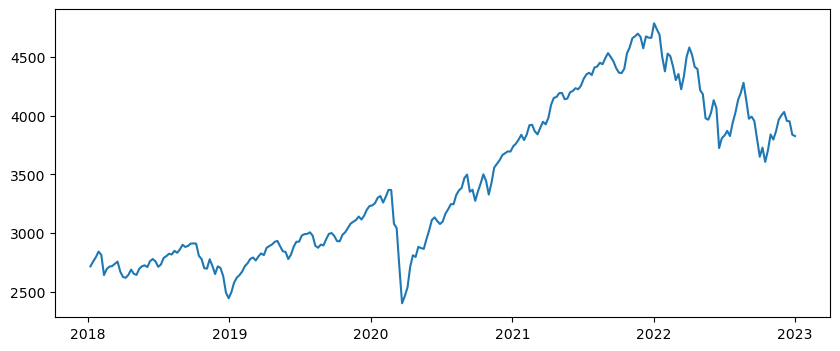

In [12]:
plt.figure(figsize=(10,4))
plt.plot(df_close.index, close_data_sp500);

# Grade 4

In [13]:
p_values=[]
for i in range(log_returns.shape[1]):
    result = adfuller(log_returns[:,i])
    p_value = result[1]
    p_values.append(p_value)


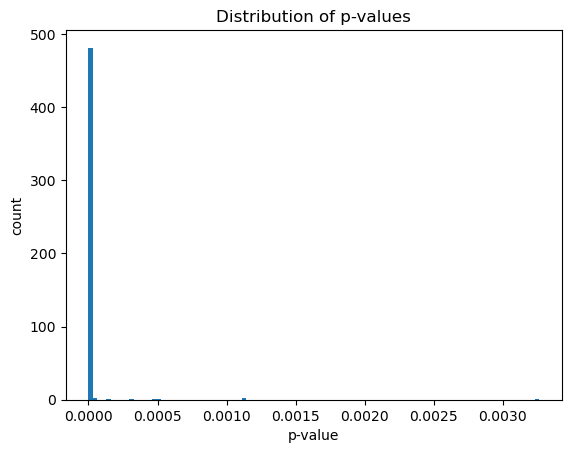

In [14]:
plt.hist(p_values, bins=100)
plt.xlabel('p-value')
plt.ylabel('count')
plt.title('Distribution of p-values')
plt.show()

In [15]:
max(p_values)

0.0032646802683453345

From the histogram, we can see that all p-values are extremely low. This lets us reject the null hypothesis of non-stationarity being true if we use a significance level of alpha = 0.05. We can therefore conclude that the 500 S&P time series we have here is stationary. Non-stationarity is hard to model therefore it is a good sign that our time series is stationary.

In [16]:
log_returns.shape

(260, 491)

In [17]:
from sklearn.decomposition import PCA
pca = PCA(n_components=0.99, svd_solver='full')
log_returns_pca = pca.fit_transform(log_returns)
log_returns_pca.shape

(260, 189)

# Grade 3

In [18]:
# Lower dimensionality ot reduce training times
pca = PCA(n_components=10)
log_returns_pca = pca.fit_transform(log_returns) 

In [19]:
log_returns_pca.shape


(260, 10)

In [20]:
# add 0 as log_return for day one
log_returns_pca= np.insert(log_returns_pca, 0, np.zeros(log_returns_pca.shape[1]), 0)  
log_returns_pca.shape

(261, 10)

In [21]:
df_log_returns = pd.DataFrame(log_returns_pca, index=index_data.index, columns=np.arange(log_returns_pca.shape[1]))
df_log_returns.head()

,0,1,2,3,4,5,6,7,8,9
Date,,,,,,,,,,
2018-01-07,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2018-01-14,-0.276513,0.048453,0.184121,0.105217,0.148991,0.059051,0.215202,0.055261,-0.017840,0.006245
2018-01-21,-0.186830,0.029921,0.065548,0.037914,0.174895,0.024019,0.191827,0.046859,0.033521,-0.091173
2018-01-28,-0.283550,0.120460,0.078451,-0.042594,-0.057641,0.044332,0.081751,0.050701,0.017887,-0.000037
2018-02-04,0.297795,0.038137,-0.096973,0.060916,0.010914,0.109853,0.083671,0.025084,-0.055815,0.102757


In [22]:
dataset = pd.concat([df_close, df_log_returns], axis=1)

In [23]:
dataset.head()

,A,AAL,AAP,AAPL,ABBV,ABC,ABT,ACGL,ACN,ADBE,...,0,1,2,3,4,5,6,7,8,9
Date,,,,,,,,,,,,,,,,,,,,,
2018-01-07,66.243853,51.328357,101.277582,41.094573,77.594254,86.812057,53.718947,29.479166,143.620029,181.824997,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2018-01-14,68.284851,53.193380,104.241264,41.554583,77.889865,89.817969,53.814432,29.460667,147.027557,188.563998,...,-0.276513,0.048453,0.184121,0.105217,0.148991,0.059051,0.215202,0.055261,-0.017840,0.006245
2018-01-21,69.351517,56.662216,107.191944,42.310461,81.374081,92.288202,54.042306,30.286666,147.870213,195.220001,...,-0.186830,0.029921,0.065548,0.037914,0.174895,0.024019,0.191827,0.046859,0.033521,-0.091173
2018-01-28,70.984413,54.054984,111.914146,41.342848,86.039815,95.545868,56.315286,30.934001,148.825458,198.903998,...,-0.283550,0.120460,0.078451,-0.042594,-0.057641,0.044332,0.081751,0.050701,0.017887,-0.000037
2018-02-04,70.186473,51.768420,109.628255,39.432560,91.217331,92.346550,57.162331,30.352000,147.477951,197.981998,...,0.297795,0.038137,-0.096973,0.060916,0.010914,0.109853,0.083671,0.025084,-0.055815,0.102757


In [24]:
# split data into train and test partitions

end_train = int(dataset.shape[0] * 0.8)

train = dataset.iloc[:end_train, :].copy()
test = dataset.iloc[end_train:, :].copy()

print(f"whole data shape: {dataset.shape}")
print(f"train data shape: {train.shape}")
print(f"test data shape: {test.shape}")
print(f"train data percentage: {train.shape[0] / index_data.shape[0] * 100}")
print(f"test data percentage: {test.shape[0] / index_data.shape[0] * 100}")

whole data shape: (261, 501)
train data shape: (208, 501)
test data shape: (53, 501)
train data percentage: 79.6934865900383
test data percentage: 20.306513409961685


In [25]:
from skforecast.ForecasterAutoregMultiVariate import ForecasterAutoregMultiVariate
from skforecast.model_selection_multiseries import backtesting_forecaster_multiseries
from skforecast.model_selection_multiseries import grid_search_forecaster_multiseries
from skforecast.model_selection_multiseries import random_search_forecaster_multiseries
from sklearn.ensemble import RandomForestRegressor


In [25]:
forecaster = ForecasterAutoregMultiVariate(
                 regressor          = RandomForestRegressor(random_state=123),
                 level              = '^GSPC',
                 lags               = 7,
                 steps              = test.shape[0],
                 transformer_series = None,
                 transformer_exog   = None,
                 weight_func        = None
             )


lags_grid = [5,10, 50]
param_distributions = {'n_estimators': np.arange(start=15, stop=20, step=1, dtype=int),
                       'max_depth': [5, 10]}



results = random_search_forecaster_multiseries(
              forecaster          = forecaster,
              series              = dataset,
              exog                = None,
              lags_grid           = lags_grid,
              param_distributions = param_distributions,
              steps               = test.shape[0],
              metric              = 'mean_absolute_error',
              initial_train_size  = len(train),
              refit               = False,
              fixed_train_size    = False,
              n_iter              = 5,
              return_best         = False,
              verbose             = False
          )

results

15 models compared for 1 level(s). Number of iterations: 15.


loop lags_grid: 100%|█████████████████████████████████████| 3/3 [50:38<00:00, 1012.74s/it]


,levels,lags,params,mean_absolute_error,n_estimators,max_depth
2,[^GSPC],"[1, 2, 3, 4, 5]","{'n_estimators': 17, 'max_depth': 10}",542.094243,17,10
4,[^GSPC],"[1, 2, 3, 4, 5]","{'n_estimators': 18, 'max_depth': 10}",546.784447,18,10
1,[^GSPC],"[1, 2, 3, 4, 5]","{'n_estimators': 15, 'max_depth': 5}",547.870695,15,5
3,[^GSPC],"[1, 2, 3, 4, 5]","{'n_estimators': 15, 'max_depth': 10}",549.740759,15,10
0,[^GSPC],"[1, 2, 3, 4, 5]","{'n_estimators': 19, 'max_depth': 5}",555.412333,19,5
11,[^GSPC],"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'n_estimators': 15, 'max_depth': 5}",598.741434,15,5
14,[^GSPC],"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'n_estimators': 18, 'max_depth': 10}",600.742127,18,10
12,[^GSPC],"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'n_estimators': 17, 'max_depth': 10}",603.498651,17,10
10,[^GSPC],"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'n_estimators': 19, 'max_depth': 5}",605.517762,19,5
13,[^GSPC],"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'n_estimators': 15, 'max_depth': 10}",607.892153,15,10


In [26]:
# model with optimized parameters

forecaster = ForecasterAutoregMultiVariate(
                 regressor          = RandomForestRegressor(random_state=123, n_estimators=17, max_depth=10),
                 level              = '^GSPC',
                 lags               = 5,
                 steps              = test.shape[0],
                 transformer_series = None,
                 transformer_exog   = None,
                 weight_func        = None
             )
forecaster.fit(series=train)
forecaster

ForecasterAutoregMultiVariate 
Regressor: RandomForestRegressor(max_depth=10, n_estimators=17, random_state=123) 
Lags: [1 2 3 4 5] 
Transformer for series: None 
Transformer for exog: None 
Weight function included: False 
Window size: 5 
Target series, level: ^GSPC 
Multivariate series (names): ['A', 'AAL', 'AAP', 'AAPL', 'ABBV', 'ABC', 'ABT', 'ACGL', 'ACN', 'ADBE', 'ADI', 'ADM', 'ADP', 'ADSK', 'AEE', 'AEP', 'AES', 'AFL', 'AIG', 'AIZ', 'AJG', 'AKAM', 'ALB', 'ALGN', 'ALK', 'ALL', 'ALLE', 'AMAT', 'AMCR', 'AMD', 'AME', 'AMGN', 'AMP', 'AMT', 'AMZN', 'ANET', 'ANSS', 'AON', 'AOS', 'APA', 'APD', 'APH', 'APTV', 'ARE', 'ATO', 'ATVI', 'AVB', 'AVGO', 'AVY', 'AWK', 'AXP', 'AZO', 'BA', 'BAC', 'BALL', 'BAX', 'BBWI', 'BBY', 'BDX', 'BEN', 'BG', 'BIIB', 'BIO', 'BK', 'BKNG', 'BKR', 'BLK', 'BMY', 'BR', 'BRO', 'BSX', 'BWA', 'BXP', 'C', 'CAG', 'CAH', 'CAT', 'CB', 'CBOE', 'CBRE', 'CCI', 'CCL', 'CDNS', 'CDW', 'CE', 'CF', 'CFG', 'CHD', 'CHRW', 'CHTR', 'CI', 'CINF', 'CL', 'CLX', 'CMA', 'CMCSA', 'CME', 'CMG',

In [27]:
predictions = forecaster.predict()
print('As many steps are predicted as have been defined in the initialization.')
display(predictions)

As many steps are predicted as have been defined in the initialization.


,^GSPC
2022-01-02,3592.698909
2022-01-09,3644.814670
2022-01-16,3617.574970
2022-01-23,3682.696039
2022-01-30,3746.917592
2022-02-06,3706.671567
2022-02-13,3702.732655
2022-02-20,3441.106441
2022-02-27,3198.746467
2022-03-06,3110.761936


In [28]:
predictions.shape

(53, 1)

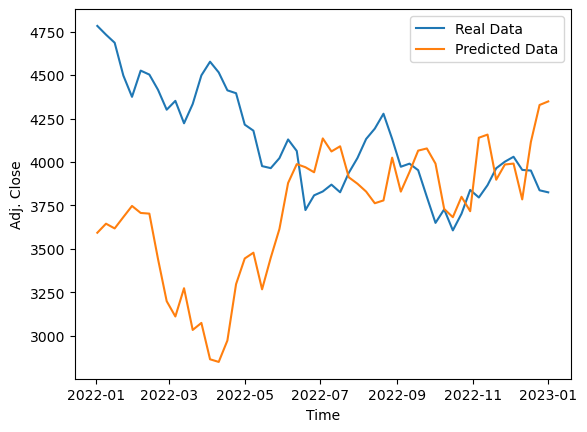

In [29]:
# Plot real data and predicted data
plt.plot(test.index, test.loc[:,"^GSPC"], label='Real Data')
plt.plot(test.index, predictions, label='Predicted Data')

# Add legend and labels
plt.legend()
plt.xlabel('Time')
plt.ylabel('Adj. Close')

# Show the plot
plt.show()

In [30]:
metrics_levels, backtest_predictions = backtesting_forecaster_multiseries(
                                           forecaster         = forecaster,
                                           series             = dataset,
                                           steps              = test.shape[0],
                                           metric             = 'mean_absolute_error',
                                           initial_train_size = len(train),
                                           refit              = False,
                                           fixed_train_size   = False,
                                           verbose            = False
                                       )

print("Backtest metrics")
display(metrics_levels)
print("")
print("Backtest predictions")
backtest_predictions.head(4)

Backtest metrics


,levels,mean_absolute_error
0,^GSPC,542.094243



Backtest predictions


,^GSPC
2022-01-02,3592.698909
2022-01-09,3644.814670
2022-01-16,3617.574970
2022-01-23,3682.696039


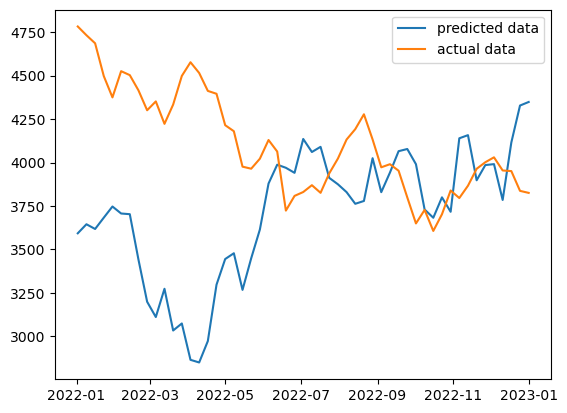

In [31]:
plt.plot(predictions, label="predicted data")
plt.plot(dataset["^GSPC"].iloc[train.shape[0]:], label="actual data")
plt.legend()
plt.show()

# Grade 2

Rips(maxdim=2, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)


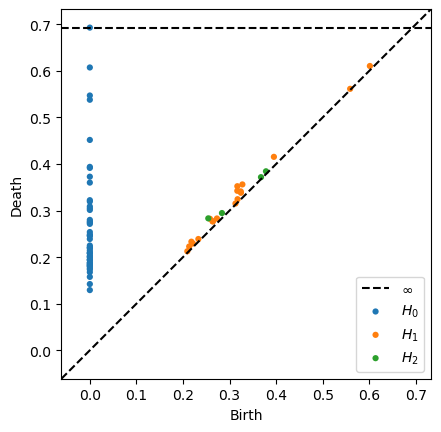

In [32]:
window_size = 50
i = 2

rips = Rips(maxdim=2)
diagrams = rips.fit_transform(log_returns_pca[i:i+window_size,:])
rips.plot(diagrams)

In the above persistence diagram, the blue dots are the connected components the orange dots correspond to Holes and the green dots represent Cavities. In this case, we can not see any significant values as most of the dots lie close to the y(x)=x line indicating that their features birth and death are very close. This could be due to the fact that each data point resembles an average of one week's worth of data, resulting in inaccurate results. Still, we can say that the holes and cavities that do occur indicate longer-term patterns or trends in the financial data.

# Grade 1

In [32]:
# inspired by: https://medium.datadriveninvestor.com/persistent-homology-f22789d753c4

# instantiate Vietoris-Rips solver
rips = Rips(maxdim = 2)

# just to make sure we have the right data
analysed_data = log_returns_pca

# time window size
w = 20
# number of time segments
n = len(analysed_data)-(2*w)+1
# initialize array for wasserstein distances
wasserstein_dists = np.zeros((n,1))
persistent_entropies = np.zeros((n,1))
# compute wasserstein distances between persistence diagrams for subsequent time windows
for i in range(n):
    # compute persistence diagrams for adjacent time windows
    dgm1 = rips.fit_transform(analysed_data[i:i+w])
    dgm2 = rips.fit_transform(analysed_data[i+w+1:i+(2*w)+1])

    # compute persistent entropy
    persistent_entropies[i] = persistent_entropy(dgm1[0])

    # compute wasserstein distance between diagrams
    wasserstein_dists[i] = wasserstein(dgm1[0], dgm2[0], matching=False)

Rips(maxdim=2, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
(261, 10)


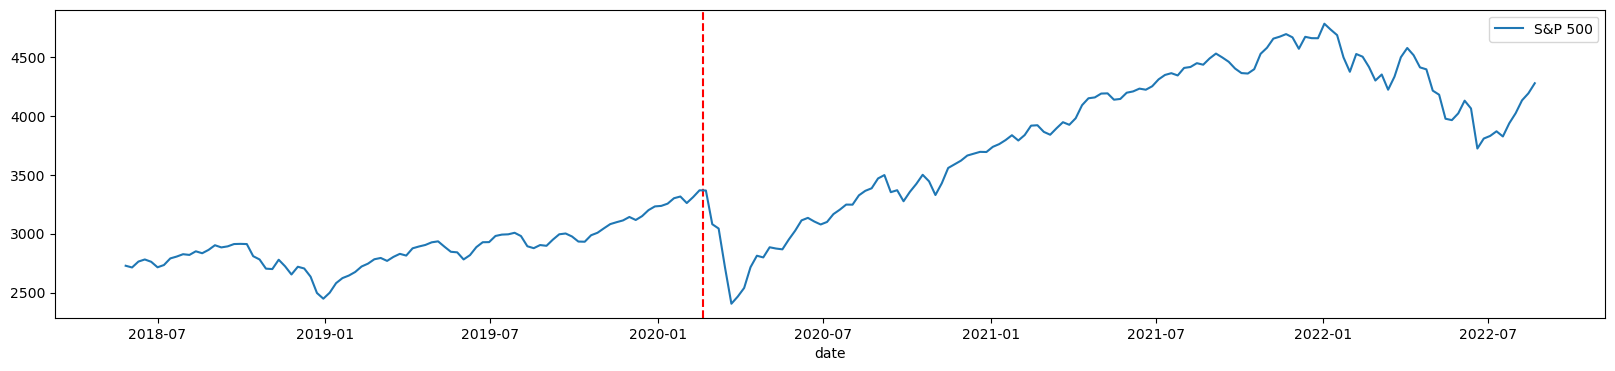

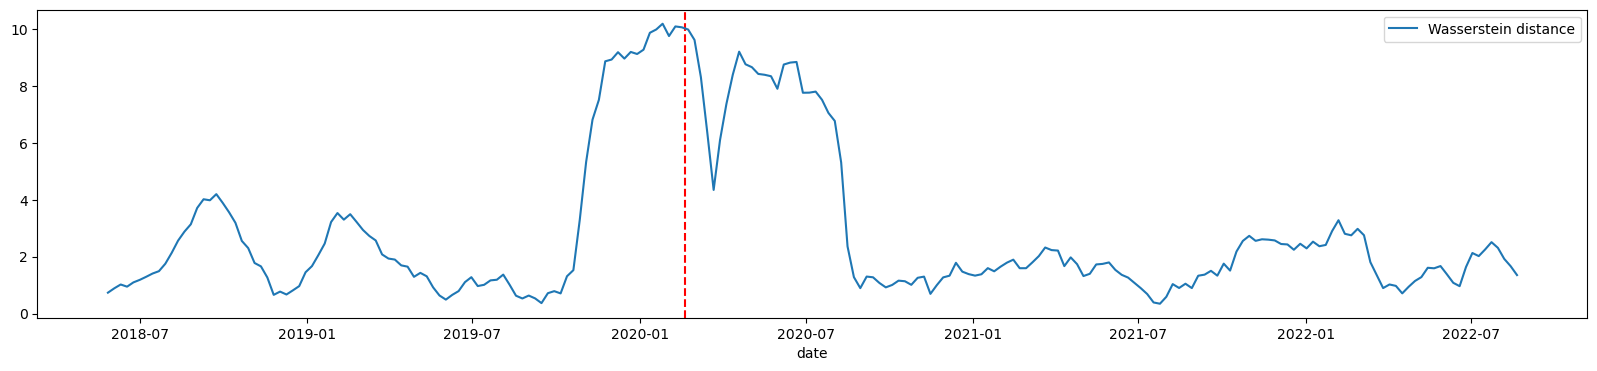

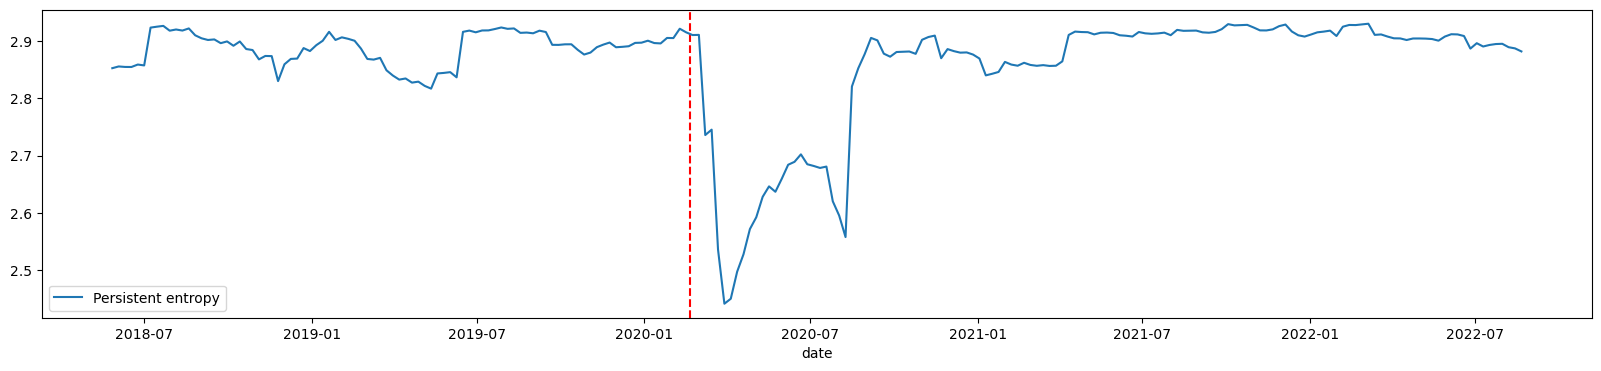

In [28]:
from datetime import datetime

plt.figure(figsize=(20, 4))
plt.axvline(datetime(2020, 2, 20), color='r', linestyle='--')
plt.plot(index_data.index[w:n+w], close_data_sp500[w:n+w], label="S&P 500")
plt.xlabel("date")
plt.legend()
plt.show()

plt.figure(figsize=(20, 4))
plt.axvline(datetime(2020, 2, 20), color='r', linestyle='--')
plt.plot(index_data.index[w:n+w], wasserstein_dists, label="Wasserstein distance")
plt.legend()
plt.xlabel("date")
plt.show()

plt.figure(figsize=(20, 4))
plt.axvline(datetime(2020, 2, 20), color='r', linestyle='--')
plt.plot(index_data.index[w:n+w], persistent_entropies, label="Persistent entropy")
plt.xlabel("date")
plt.legend()
plt.show()

The vertical red line is at the time the stock market crash of 2020 started. We can see before the crash the wasserstein distance is relatively low, but after the crash it increases (we used the full dataset before, but for testing and education purposes we shrank the dataset size, so the wasserstein distances are a little bit distorted here). This is because the persistence diagrams of the two time windows are very different. The persistent entropy also increases after the crash, which is also expected. This is because the persistent entropy is a measure of the number of holes in the persistence diagram. The more holes, the higher the entropy.

In [38]:
# add wasserstein and persistent entropy to train data

train["wasserstein"] = wasserstein_dists[:end_train]
train["persistent_entropy"] = persistent_entropies[:end_train]

print(train.shape)

(208, 503)


In [39]:
forecaster = ForecasterAutoregMultiVariate(
    regressor          = RandomForestRegressor(random_state=123, n_estimators=17, max_depth=10),
    level              = '^GSPC',
    lags               = 5,
    steps              = test.shape[0],
    transformer_series = None,
    transformer_exog   = None,
    weight_func        = None
)

forecaster.fit(series=train)

In [40]:
predictions = forecaster.predict()

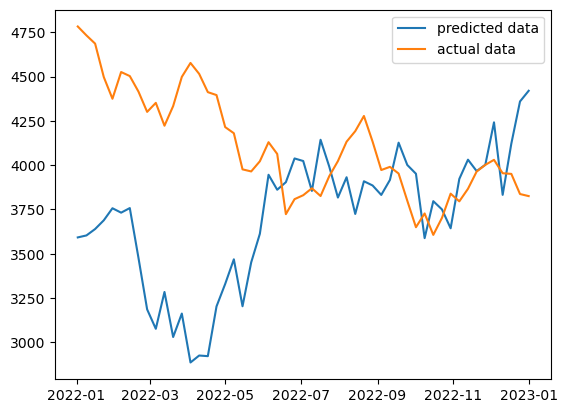

In [41]:
plt.plot(predictions, label="predicted data")
plt.plot(dataset["^GSPC"].iloc[train.shape[0]:], label="actual data")
plt.legend()
plt.show()

In [42]:
metrics_levels, backtest_predictions = backtesting_forecaster_multiseries(
    forecaster         = forecaster,
    series             = dataset,
    steps              = test.shape[0],
    metric             = 'mean_absolute_error',
    initial_train_size = len(train),
    refit              = False,
    fixed_train_size   = False,
    verbose            = False
)

print("Backtest metrics")
display(metrics_levels)
print("")
print("Backtest predictions")
backtest_predictions.head(4)

Backtest metrics


,levels,mean_absolute_error
0,^GSPC,536.886133



Backtest predictions


,^GSPC
2022-01-02,3594.015672
2022-01-09,3709.292977
2022-01-16,3656.469784
2022-01-23,3686.604959


Adding the Wasserstein distances and the persistent entropy to our test data reduces our mean absolute error slightly. However, when plotting the predicted data against the real data, we are not able this a big difference to not adding these quantities.
In summary, we can say that financial data has shape and its shape can be used as a prediction feature. In this instance, we summarize a lot of data which probably minimizes the effect of the shape of the data as essential smaller shapes get lost.
When we do this experiment over the whole dataset, we'll probably see better results and an increased effect of including the shape of financial data as a feature. 